In [1]:
import numpy as np
import pandas as  pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier      
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
import statistics
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score

In [2]:
import pandas as  pd
bids_df= pd.read_csv('data/bids.csv')
df_train= pd.read_csv('data/train.csv')
test_df= pd.read_csv('data/test.csv')


In [3]:
bids_unique= bids_df.groupby('bidder_id').nunique()
bids_unique = bids_unique.drop(["bid_id"],axis = 1)

In [4]:
join_result= df_train.merge(bids_unique, how= 'left', on = 'bidder_id')
join_result.fillna(0,inplace = True)

In [5]:
bids_df_count= bids_df.groupby("bidder_id")
counts= bids_df_count['url'].count().reset_index().rename(columns = {'url':'num_bids'})

In [110]:
new_train= join_result.merge(counts, how= 'left')

In [111]:
new_train.isnull().sum()


bidder_id           0
payment_account     0
address             0
outcome             0
auction             0
merchandise         0
device              0
time                0
country             0
ip                  0
url                 0
num_bids           29
dtype: int64

In [112]:
new_train.dropna(inplace=True)

In [113]:

new_train.drop(['bidder_id','payment_account','address'],axis=1,inplace = True)


EDA

/Users/brennanszeto/Environments/dsvenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='outcome', ylabel='count'>

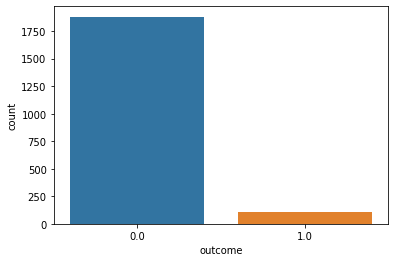

In [114]:
import seaborn as sns
sns.countplot(new_train['outcome'],label="Count")

In [115]:
new_train.corr()

,outcome,auction,merchandise,device,time,country,ip,url,num_bids
outcome,1.000000,0.131014,-0.005255,0.105990,0.057541,0.130027,0.083686,0.017358,0.039103
auction,0.131014,1.000000,0.121288,0.904272,0.598344,0.821531,0.584278,0.572812,0.503148
merchandise,-0.005255,0.121288,1.000000,0.082965,0.045682,0.075424,0.057622,0.049119,0.030641
device,0.105990,0.904272,0.082965,1.000000,0.707228,0.838619,0.663759,0.687681,0.629752
time,0.057541,0.598344,0.045682,0.707228,1.000000,0.438429,0.945592,0.900077,0.979416
country,0.130027,0.821531,0.075424,0.838619,0.438429,1.000000,0.468465,0.394982,0.349503
ip,0.083686,0.584278,0.057622,0.663759,0.945592,0.468465,1.000000,0.776280,0.887196
url,0.017358,0.572812,0.049119,0.687681,0.900077,0.394982,0.776280,1.000000,0.908388
num_bids,0.039103,0.503148,0.030641,0.629752,0.979416,0.349503,0.887196,0.908388,1.000000


Text(0.5, 1.05, 'Correlation of new_train Features')

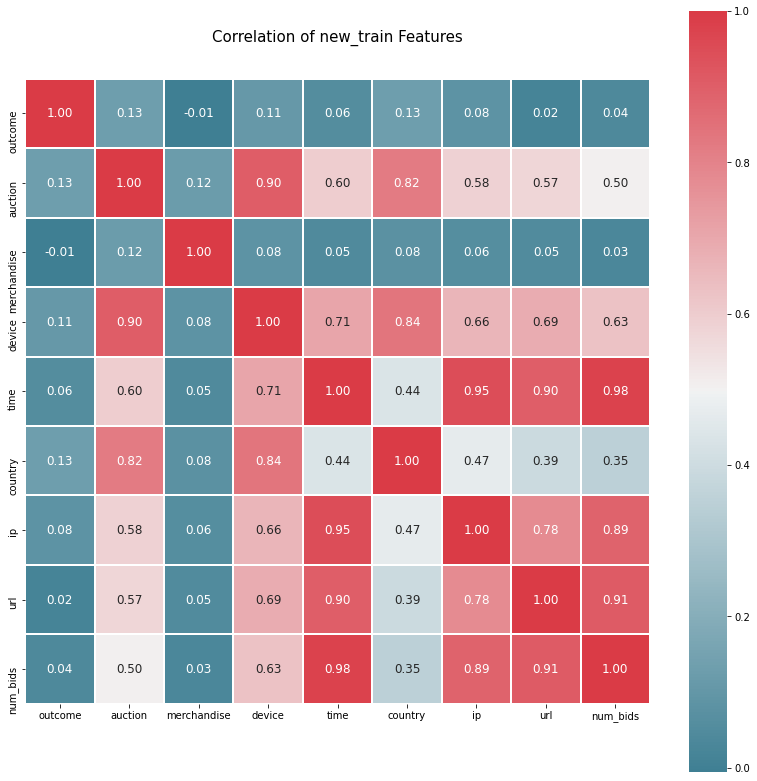

In [117]:
import matplotlib.pyplot as plt
corr = new_train.iloc[:,:].corr()
colormap = sns.diverging_palette(220, 10, as_cmap = True)
plt.figure(figsize=(14,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 12},
            cmap = colormap, linewidths=0.1, linecolor='white')
plt.title('Correlation of new_train Features', y=1.05, size=15)

Preprocessing

In [118]:
#one hot encode on merchandise
from sklearn.preprocessing import OneHotEncoder
# x=  new_train.merchandise
one_hot = pd.get_dummies(new_train['merchandise'])
new_train.drop('merchandise',axis=1,inplace= True)
new_train= new_train.join(one_hot)
new_train = new_train.rename(columns={1.0:'merchandise=1.0',2.0:'merchandise=2.0'})
new_train

,outcome,auction,device,time,country,ip,url,num_bids,merchandise=1.0,merchandise=2.0
0,0.0,18.0,14.0,24.0,6.0,20.0,1.0,24.0,1,0
1,0.0,1.0,2.0,3.0,1.0,3.0,2.0,3.0,1,0
2,0.0,4.0,2.0,4.0,1.0,4.0,2.0,4.0,1,0
3,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,0
4,0.0,23.0,53.0,155.0,2.0,123.0,91.0,155.0,1,0
...,...,...,...,...,...,...,...,...,...,...
2008,0.0,25.0,4.0,33.0,4.0,5.0,2.0,36.0,1,0
2009,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,0
2010,0.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,1,0
2011,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,0


In [122]:
X=new_train.drop('outcome',axis =1)
y= new_train['outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)


In [123]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [126]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [135]:
classifier = Sequential()
classifier.add(Dense(6,activation = 'relu'))
classifier.add(Dense(6, activation = 'relu'))
classifier.add(Dense(1, activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [136]:
classifier.fit(X_train, y_train, batch_size = 10, epochs = 10)

Epoch 1/10
159/159 [==============================] - 17s 680us/step - loss: 0.5950 - accuracy: 0.9448
Epoch 2/10
159/159 [==============================] - 0s 630us/step - loss: 0.2589 - accuracy: 0.9573
Epoch 3/10
159/159 [==============================] - 0s 654us/step - loss: 0.2015 - accuracy: 0.9422
Epoch 4/10
159/159 [==============================] - 0s 571us/step - loss: 0.1975 - accuracy: 0.9459
Epoch 5/10
159/159 [==============================] - 0s 598us/step - loss: 0.2003 - accuracy: 0.9440
Epoch 6/10
159/159 [==============================] - 0s 650us/step - loss: 0.2007 - accuracy: 0.9414
Epoch 7/10
159/159 [==============================] - 0s 647us/step - loss: 0.1924 - accuracy: 0.9442
Epoch 8/10
159/159 [==============================] - 0s 576us/step - loss: 0.1814 - accuracy: 0.9477
Epoch 9/10
159/159 [==============================] - 0s 642us/step - loss: 0.2014 - accuracy: 0.9411
Epoch 10/10
159/159 [==============================] - 0s 593us/step - loss: 0.18

In [ ]:
y_pred = classifier.predict(X_test)
roc_auc_score(y_test,y_pred)